In [ ]:
# Install dependencies
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer

In [ ]:

from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train", {}, "/content/drive/MyDrive/brain_tumor_detectron2/train_coco.json", "/content/drive/MyDrive/brain_tumor_detectron2/train")
register_coco_instances("dataset_val", {}, "/content/drive/MyDrive/brain_tumor_detectron2/test_coco.json", "/content/drive/MyDrive/brain_tumor_detectron2/test")

train_metadata = MetadataCatalog.get("dataset_train")
train_dataset_dicts = DatasetCatalog.get("dataset_train")

val_metadata = MetadataCatalog.get("dataset_val")
val_dataset_dicts = DatasetCatalog.get("dataset_val")

/content/drive/MyDrive/brain_tumor_detectron2/train/1780_jpg.rf.d008b7b462a558f0aaeb9160795f9ffe.jpg


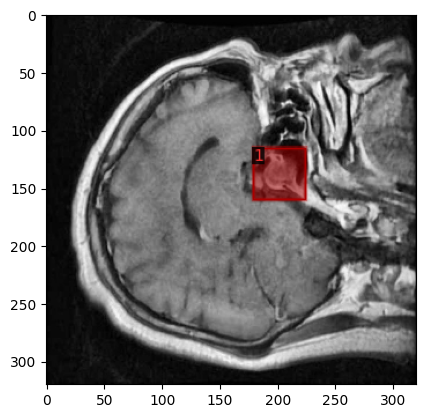

In [ ]:
# Visualize some random samples
# Note: 0: no tumor, 1: tumor

for d in random.sample(train_dataset_dicts, 1):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/brain_tumor_detectron2/output"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # batch size
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2500
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

In [ ]:
trainer.train()

%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import yaml

config_yaml_path = "/content/drive/MyDrive/brain_tumor_detectron2/output/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [ ]:
# Inference should use the config with parameters that are used in training

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

File name:  /content/drive/MyDrive/brain_tumor_detectron2/test/2924_jpg.rf.1faf11f7c125adc8f124030599a3719d.jpg
Area:  5163
Centroid:  (0.0, 350.81328684873137, 356.1392601200852)
bbox:  (0, 310, 325, 1, 393, 388)


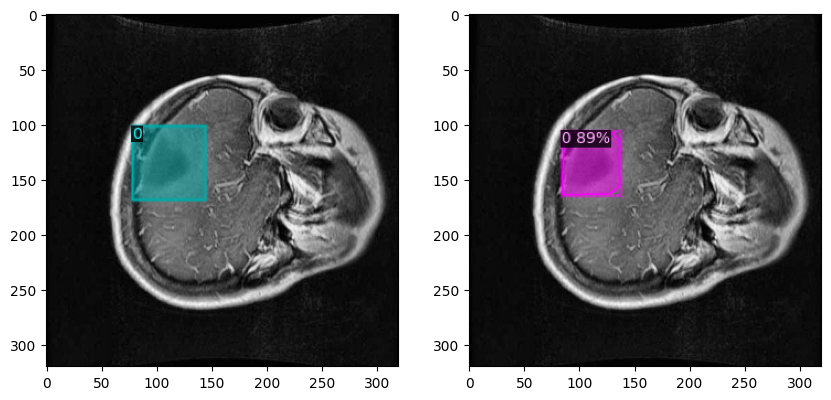

In [12]:
from detectron2.utils.visualizer import ColorMode
from skimage.measure import regionprops, label

for d in random.sample(val_dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    print('File name: ',d["file_name"])

    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)

    outputs = predictor(img)
    # Convert the predicted mask to a binary mask
    mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)
    # Use skimage.measure.regionprops to calculate object parameters
    labeled_mask = label(mask)
    for i, prop in enumerate(props):
      area = prop.area
      centroid = prop.centroid
      bounding_box = prop.bbox

      print('Area: ',area)
      print('Centroid: ',centroid)
      print('bbox: ',bounding_box)

    v = Visualizer(img[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(10, 20))
    plt.subplot(1,2,1)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.subplot(1,2,2)
    plt.imshow(out.get_image()[:, :, ::-1])
